In [294]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit 
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
% matplotlib inline

In [9]:
# Импортируем сырые данные

raw_data = pd.read_csv('Car_data_list.csv', index_col = 'Id')
raw_data.head()

,Raw_price,Price,Year,Raw_mileage,Mileage,Raw_engine,Volume,Gearbox,Private,3-doors
Id,,,,,,,,,,
1,"490000,00",490000,2011,75000,75000,1.4 AMT,1.4,A,1,1
2,910 000 ₽,910000,2011,16150,16150,1.4 MT,1.4,M,1,0
3,480 000 ₽,480000,2010,175 000 км,175000,1.4 AMT,1.4,A,1,0
4,415 000 ₽,415000,2010,87 000 км,87000,1.6 AMT,1.6,A,0,1
5,449 000 ₽,449000,2010,108 500 км,108500,1.4 AMT,1.4,A,0,1


In [271]:
# В сырых данных есть технические столбцы. Удалим их

data = raw_data.drop(['Raw_price', 'Raw_mileage', 'Raw_engine'], axis = 1)
data.head()

,Price,Year,Mileage,Volume,Gearbox,Private,3-doors
Id,,,,,,,
1,490000,2011,75000,1.4,A,1,1
2,910000,2011,16150,1.4,M,1,0
3,480000,2010,175000,1.4,A,1,0
4,415000,2010,87000,1.6,A,0,1
5,449000,2010,108500,1.4,A,0,1


In [13]:
# Проверим наличие ненулевых значений

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1 to 240
Data columns (total 7 columns):
Price      240 non-null int64
Year       240 non-null int64
Mileage    240 non-null int64
Volume     240 non-null float64
Gearbox    240 non-null object
Private    240 non-null int64
3-doors    240 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 25.0+ KB


Всего 240 записей, ненулевых значений не наблюдается

In [15]:
# Посмотрим на описание данных

data.describe()

,Price,Year,Mileage,Volume,Private,3-doors
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000
mean,486433.325000,2010.891667,100338.595833,1.464167,0.720833,0.12500
std,75588.963327,0.903696,35580.660680,0.124286,0.449527,0.33141
min,350000.000000,2008.000000,15407.000000,1.200000,0.000000,0.00000
25%,440000.000000,2010.000000,77000.000000,1.400000,0.000000,0.00000
50%,476000.000000,2011.000000,95750.000000,1.400000,1.000000,0.00000
75%,525000.000000,2012.000000,120000.000000,1.600000,1.000000,0.00000
max,910000.000000,2012.000000,233000.000000,2.000000,1.000000,1.00000


In [16]:
# Посмотрим на распределение каждого признака в отдельности, а также его зависимость от цены

In [115]:
data.Year.value_counts()

2011    98
2012    67
2010    58
2009    16
2008     1
Name: Year, dtype: int64

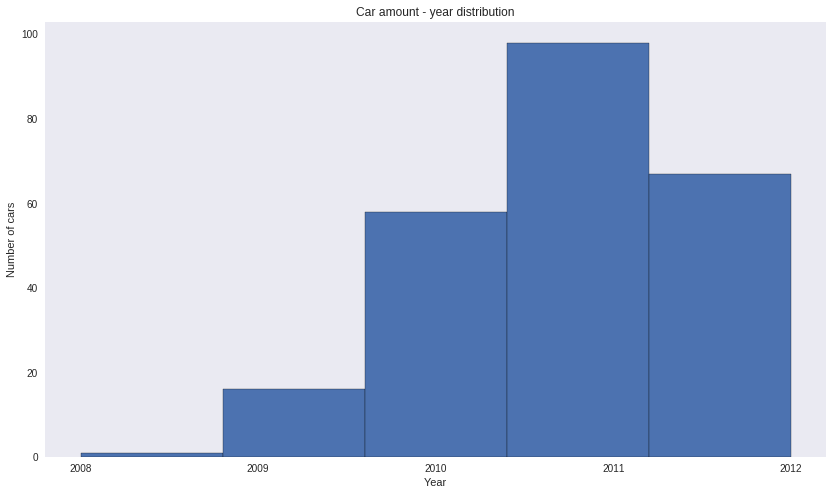

In [138]:
data['Year'].hist(figsize = (14, 8), grid = False, bins = 5, edgecolor = 'black');
plt.xlabel('Year')
plt.ylabel('Number of cars')
plt.title('Car amount - year distribution', size = 12)
plt.xticks(data['Year'].unique());

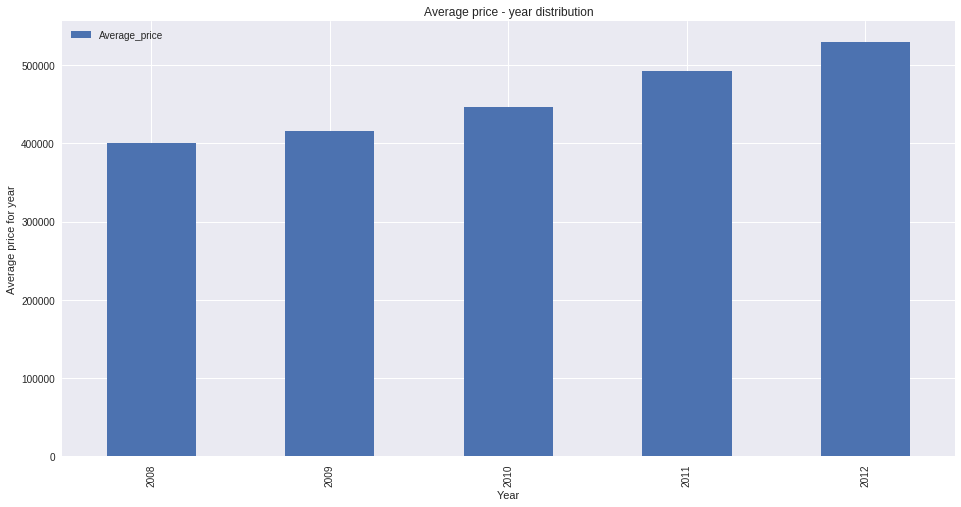

In [168]:
year_price_means = []
years = sorted(data['Year'].unique())
for year in years:
    year_price_means.append(data[data['Year'] == year]['Price'].mean())
year_price_df = pd.DataFrame(year_price_means, index=years, columns = ['Average_price'])
year_price_df.plot(kind = 'bar', figsize = (16, 8))
plt.title('Average price - year distribution', size = 12)
plt.xlabel('Year')
plt.ylabel('Average price for year');

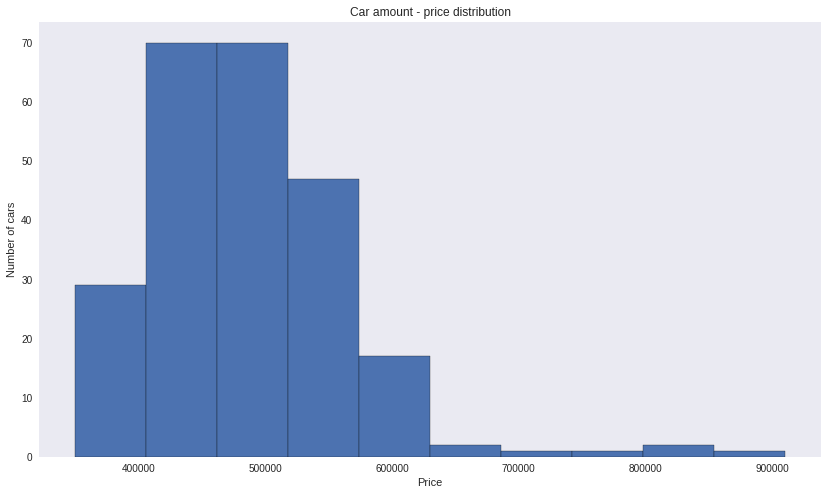

In [140]:
data['Price'].hist(figsize = (14, 8), grid = False, edgecolor = 'black');
plt.xlabel('Price')
plt.ylabel('Number of cars')
plt.title('Car amount - price distribution', size = 12);

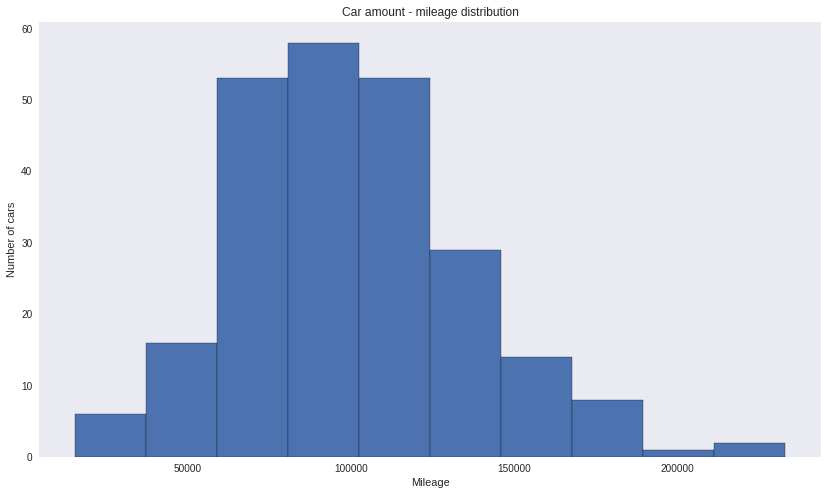

In [169]:
data['Mileage'].hist(figsize = (14, 8), grid = False, edgecolor = 'black');
plt.xlabel('Mileage')
plt.ylabel('Number of cars')
plt.title('Car amount - mileage distribution', size = 12);

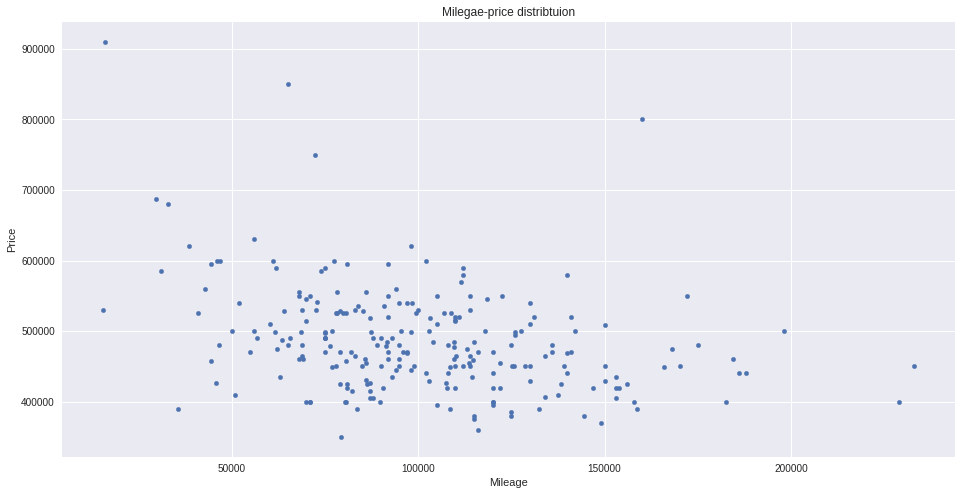

In [174]:
data.plot.scatter(x = 'Mileage', y = 'Price', figsize = (16, 8))
plt.title('Milegae-price distribtuion', size = 12);

In [175]:
data['Volume'].value_counts()

1.4    134
1.6     88
1.2     16
1.8      1
2.0      1
Name: Volume, dtype: int64

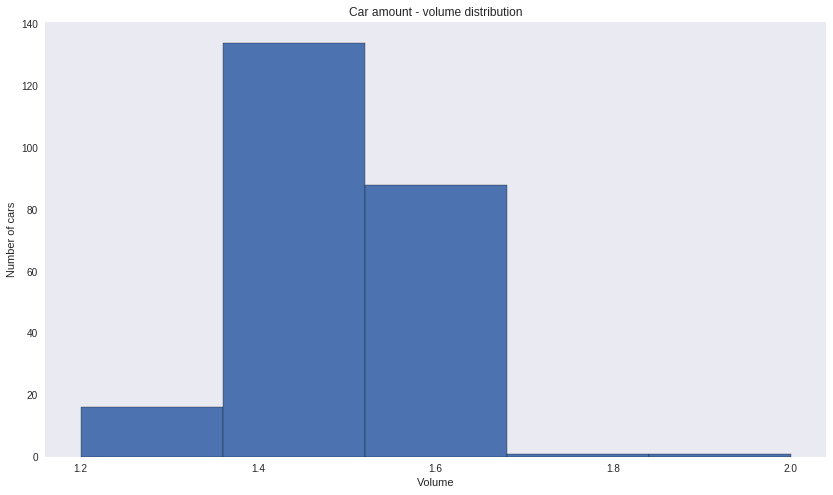

In [178]:
data['Volume'].hist(figsize = (14, 8), grid = False, edgecolor = 'black', bins = 5);
plt.xlabel('Volume')
plt.ylabel('Number of cars')
plt.xticks(data['Volume'].unique())
plt.title('Car amount - volume distribution', size = 12);

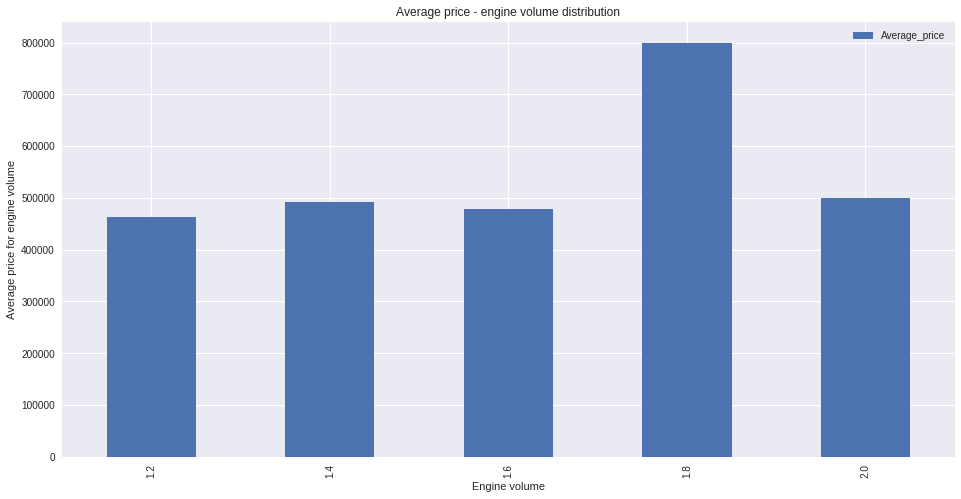

In [180]:
volume_price_means = []
volumes = sorted(data['Volume'].unique())
for volume in volumes:
    volume_price_means.append(data[data['Volume'] == volume]['Price'].mean())
volume_price_df = pd.DataFrame(volume_price_means, index=volumes, columns = ['Average_price'])
volume_price_df.plot(kind = 'bar', figsize = (16, 8))
plt.title('Average price - engine volume distribution', size = 12)
plt.xlabel('Engine volume')
plt.ylabel('Average price for engine volume');

In [199]:
data['Private'].value_counts()

1    173
0     67
Name: Private, dtype: int64

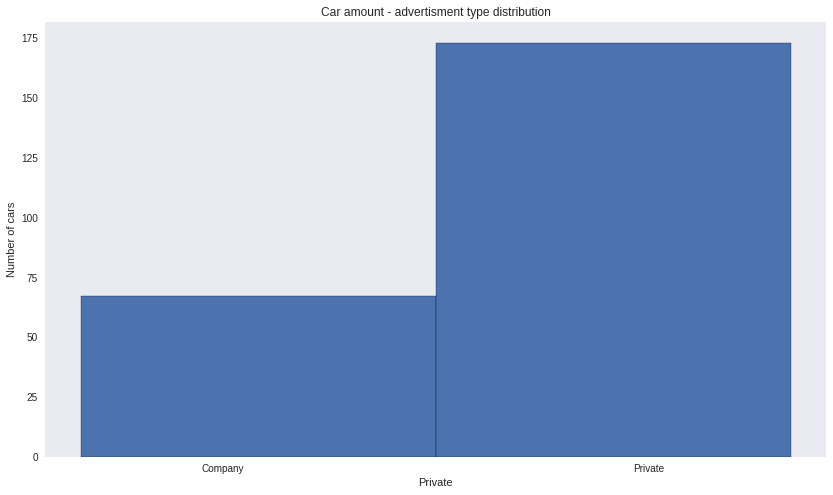

In [191]:
data['Private'].hist(figsize = (14, 8), grid = False, edgecolor = 'black', bins = 2);
plt.xlabel('Private')
plt.ylabel('Number of cars')
plt.xticks([0.2, 0.8], ['Company', 'Private'])
plt.title('Car amount - advertisment type distribution', size = 12);

Mean price for private advertisement = 462231.0
Mean price for company advertisement = 495806.0


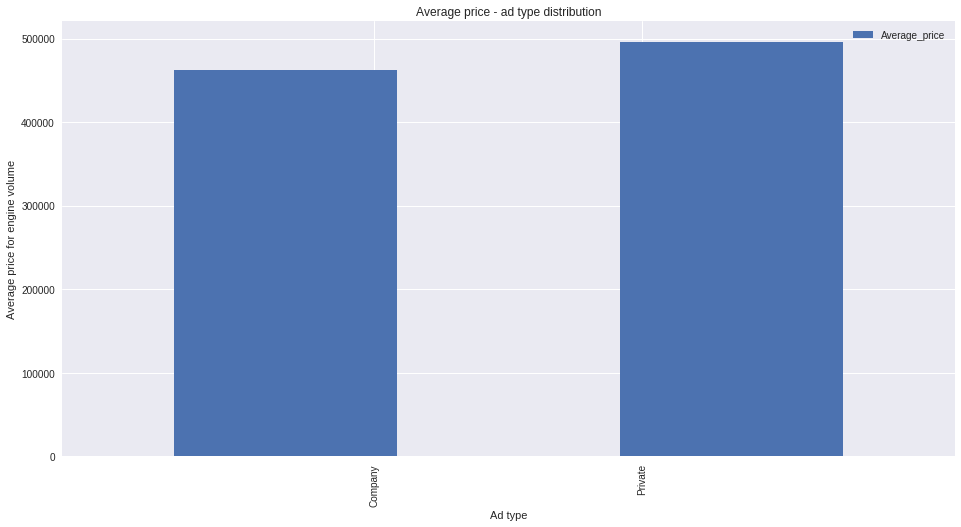

In [196]:
private_price_means = []
privates = sorted(data['Private'].unique())
for private in privates:
    private_price_means.append(data[data['Private'] == private]['Price'].mean())
private_price_df = pd.DataFrame(private_price_means, index=privates, columns = ['Average_price'])
private_price_df.plot(kind = 'bar', figsize = (16, 8))
plt.title('Average price - ad type distribution', size = 12)
plt.xlabel('Ad type')
plt.xticks([0.2, 0.8], ['Company', 'Private'])
plt.ylabel('Average price for engine volume');
print('Mean price for private advertisement = %s' % round(private_price_means[0], 0))
print('Mean price for company advertisement = %s' % round(private_price_means[1], 0))

In [200]:
data['3-doors'].value_counts()

0    210
1     30
Name: 3-doors, dtype: int64

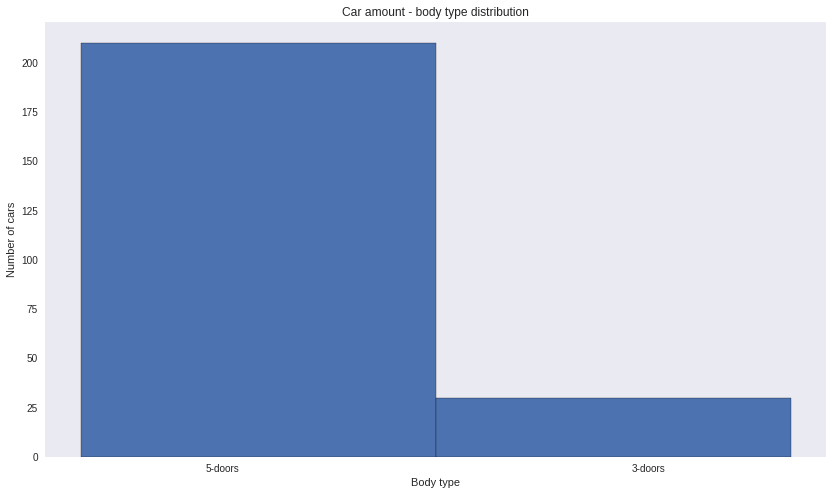

In [198]:
data['3-doors'].hist(figsize = (14, 8), grid = False, edgecolor = 'black', bins = 2);
plt.xlabel('Body type')
plt.ylabel('Number of cars')
plt.xticks([0.2, 0.8], ['5-doors', '3-doors'])
plt.title('Car amount - body type distribution', size = 12);

Mean price for 3-doors = 468783.0
Mean price for 5-doors = 488955.0


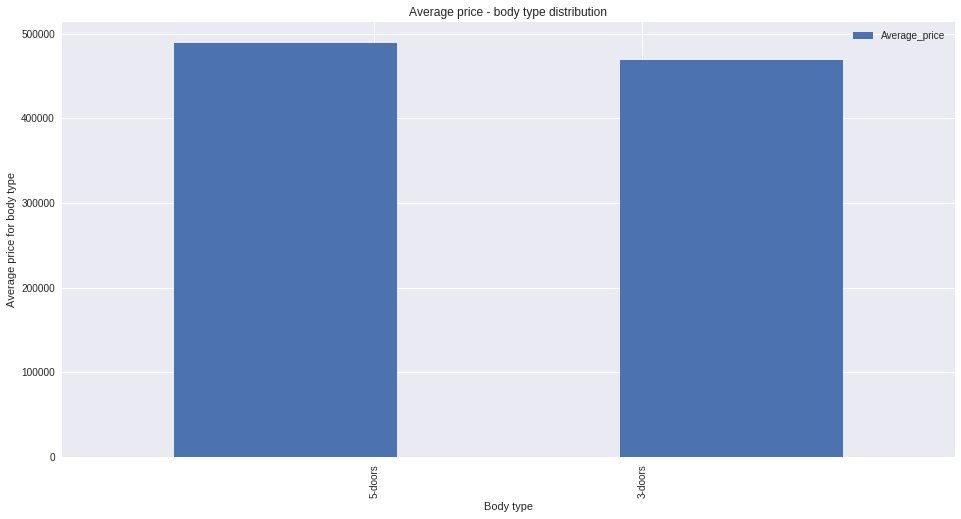

In [202]:
doors_price_means = []
doors = sorted(data['3-doors'].unique())
for door in doors:
    doors_price_means.append(data[data['3-doors'] == door]['Price'].mean())
doors_price_df = pd.DataFrame(doors_price_means, index=doors, columns = ['Average_price'])
doors_price_df.plot(kind = 'bar', figsize = (16, 8))
plt.title('Average price - body type distribution', size = 12)
plt.xlabel('Body type')
plt.xticks([0.2, 0.8], ['5-doors', '3-doors'])
plt.ylabel('Average price for body type');
print('Mean price for 3-doors = %s' % round(doors_price_means[1], 0))
print('Mean price for 5-doors = %s' % round(doors_price_means[0], 0))

In [215]:
data[(data['3-doors'] == 1) & (data['Mileage'] > 80000) & (data['Mileage'] < 120000)]['Price'].mean()

454900.0

In [383]:
data[data['Price'] > 700000]

,Price,Year,Mileage,Volume,Gearbox,Private,3-doors
Id,,,,,,,
2,910000,2011,16150,1.4,M,1,0
110,750000,2012,72500,1.4,A,1,0
214,800000,2012,160000,1.8,A,1,0
237,850000,2011,65000,1.4,M,1,1


In [384]:
df = data.drop(data[data['Price'] > 650000].index)

In [385]:
df = df.drop(data[data['Mileage'] > 200000].index)

In [386]:
df = df.drop(data[data['Volume'] == 2.0].index)

In [387]:
df.Volume.value_counts()

1.4    128
1.6     87
1.2     16
Name: Volume, dtype: int64

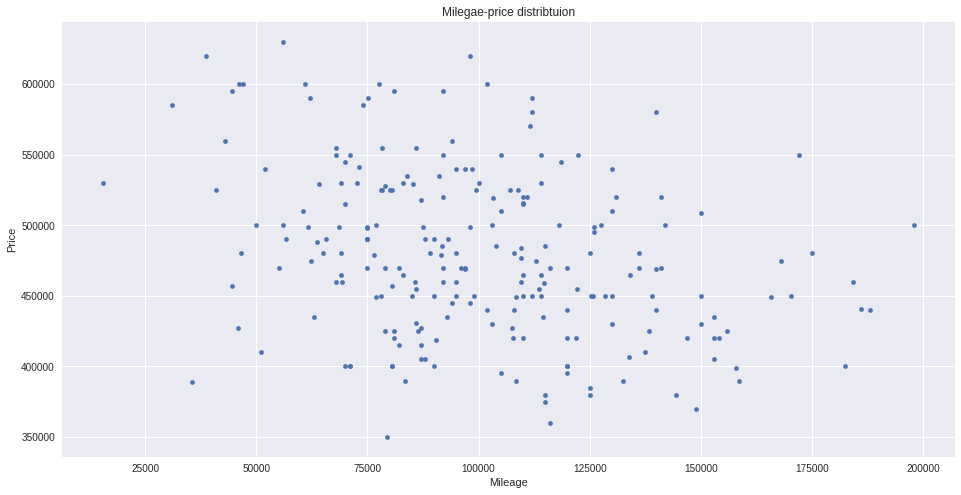

In [388]:
df.plot.scatter(x = 'Mileage', y = 'Price', figsize = (16, 8))
plt.title('Milegae-price distribtuion', size = 12);

In [421]:
df_drop = df.drop(['Mileage', 'Price'], axis = 1)
df_drop['Year'] = df_drop['Year'].astype('object')
df_drop['Volume'] = df_drop['Volume'].astype('object')
df_drop['Private'] = df_drop['Private'].astype('object')
df_drop['3-doors'] = df_drop['3-doors'].astype('object')
target = df['Price']
mileage = df['Mileage']
df_dummies = pd.get_dummies(df_drop)
df_dummies.head()

,Year_2009,Year_2010,Year_2011,Year_2012,Volume_1.2,Volume_1.4,Volume_1.6,Gearbox_A,Gearbox_M,Private_0,Private_1,3-doors_0,3-doors_1
Id,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,1,0,0,1,0,1
3,0,1,0,0,0,1,0,1,0,0,1,1,0
4,0,1,0,0,0,0,1,1,0,1,0,0,1
5,0,1,0,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,0,1,0,1,0,1,0,1,0


In [426]:
df_dummies['Mileage'] = mileage

In [ ]:
sc_mil = StandardScaler()
df_dummies['Mileage'] = sc_mil.fit_transform(mileage)

In [399]:
sc_target = StandardScaler()
target = sc_target.fit_transform(target)

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/demi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [407]:
my_mileage = (104000 - sc_mil.mean_) / sc_mil.std_

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)


In [408]:
my_mileage

0.11624841952412167

In [475]:
lasso = LassoCV(cv = skf)
lr = LinearRegression()
skf = StratifiedShuffleSplit(n_splits = 3, )

In [476]:
lasso.fit(df_dummies, target)
lr.fit(df_dummies, target)

TypeError: split() takes at least 3 arguments (2 given)

In [424]:
my_car = [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 104000]

In [429]:
lasso.predict(my_car)

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 477316.65319997])

In [430]:
lr.predict(my_car)

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 446799.75589212])

In [466]:
lasso.predict(df_dummies.iloc[0:1,:])[0]

492428.86795094004

In [473]:
lasso.predict(df_dummies.iloc[202:203,:])

array([ 463246.66015597])

In [459]:
df.iloc[0:1,:]['Mileage']

Id
1    75000
Name: Mileage, dtype: int64

In [472]:
df.iloc[202:203,:]['Mileage']

Id
210    131000
Name: Mileage, dtype: int64

In [ ]:
plt.plot([lasso.predict(df_dummies.iloc[0:1,:]),lasso.predict(df_dummies.iloc[200:201,:])],
         [df.iloc[0:1,:]['Mileage'], df.iloc[200:201,:]['Mileage']]);

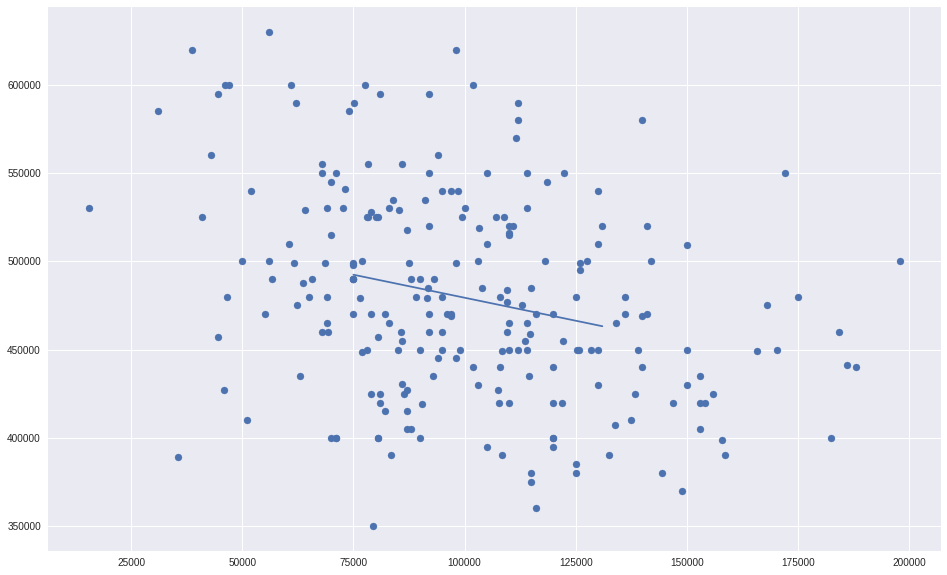

In [474]:
fig = plt.figure(figsize = (16, 10))
plt.scatter(df['Mileage'], target)
plt.plot([75000, 131000], [492428, 463246]);

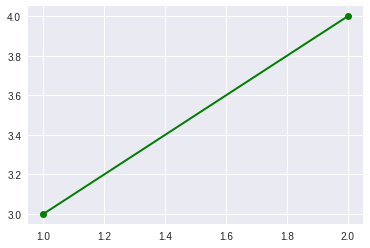

In [468]:
plt.plot([1,2], [3,4], 'go-', label='line 1', linewidth=2)

In [324]:
sc_target.inverse_transform(-0.54007131)

array(-0.54007131)

In [288]:
df_dummies.shape

(231, 14)

In [297]:
target.shape

(231,)

In [335]:
cross_val_score(lasso, df_dummies, y = target, cv = skf)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.